# MLBootcamp  V

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/competition_examples/mlbootcamp_v_tutorial.ipynb)

This code shows 7th place solution for competition of forecasting cardiovascular diseases (http://mlbootcamp.ru/round/12/sandbox/)

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tqdm
import hyperopt
import sys
import scipy

import lightgbm
from catboost import CatBoost, CatBoostClassifier

from datetime import datetime
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import log_loss

Data can be obtained from competion page, or through [this link](http://mlbootcamp.ru/media/condition/ml5.zip)

In [4]:
train_df = pd.read_csv('../ml5/train.csv', sep=';')
test_df = pd.read_csv('../ml5/test.csv', sep=';', na_values='None')

##  Data exploration

In [5]:
print train_df.shape, test_df.shape

(70000, 13) (30000, 12)


In [6]:
full_df = pd.concat([train_df, test_df], axis=0)

/place/home/d-kruchinin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


#####  height fix

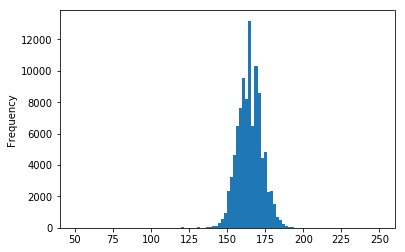

In [7]:
full_df.height.plot.hist(100)

In [8]:
full_df.loc[(full_df.height < 100), 'height'] += 100

#####  arterial pressure fix

In [9]:
full_df['ap_hi'] = full_df.ap_hi.abs()
full_df['ap_lo'] = full_df.ap_lo.abs()

In [10]:
np.percentile(full_df.ap_hi, [0.3, 99.9])

array([ 80., 215.])

In [11]:
np.percentile(full_df.ap_lo, [1, 98])

array([ 60., 110.])

In [12]:
while np.any(full_df.ap_hi > 800):
    full_df.loc[full_df.ap_hi > 800, 'ap_hi'] /= 10

In [13]:
for i in range(3):
    full_df.loc[full_df.ap_hi < 22, 'ap_hi'] *= 10

In [14]:
while np.any(full_df.ap_lo > 600):
    full_df.loc[full_df.ap_lo > 600, 'ap_lo'] /= 10

In [15]:
for i in range(3):
    full_df.loc[full_df.ap_lo < 11, 'ap_lo'] *= 10

##  Adding features

In [16]:
full_df.head()

,active,age,alco,ap_hi,ap_lo,cardio,cholesterol,gender,gluc,height,id,smoke,weight
0,1.0,18393,0.0,110.0,80.0,0.0,1,2,1,168,0,0.0,62.0
1,1.0,20228,0.0,140.0,90.0,1.0,3,1,1,156,1,0.0,85.0
2,0.0,18857,0.0,130.0,70.0,1.0,3,1,1,165,2,0.0,64.0
3,1.0,17623,0.0,150.0,100.0,1.0,1,2,1,169,3,0.0,82.0
4,0.0,17474,0.0,100.0,60.0,0.0,1,1,1,156,4,0.0,56.0


In [17]:
full_df['bmi'] = full_df.weight / ((full_df.height / 100) ** 2)

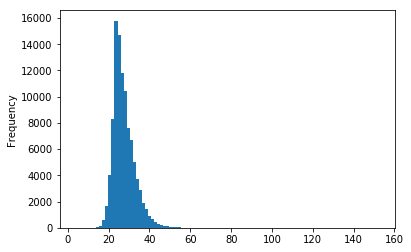

In [18]:
full_df.bmi.plot.hist(100)

#  Split back

In [19]:
train_df = full_df[~full_df.cardio.isnull()]
test_df = full_df[full_df.cardio.isnull()].drop('cardio', axis=1)

##  Model train

In [20]:
columns_with_nulls = test_df.columns[test_df.isnull().sum(axis=0) > 0]

In [21]:
X = train_df.drop(['id','cardio'], axis=1)
y = train_df.cardio

In [22]:
X_test = test_df.drop(['id'], axis=1)
X_test = X_test.fillna(-999)

In [23]:
models = []

np.random.seed(42)
for i in tqdm.tqdm_notebook(range(100)):
    X_train = X.copy()
    for col in columns_with_nulls:
        _idx = np.random.choice(X_train.index, size=X_train.shape[0]//10, replace=False)
        X_train.loc[_idx, col] = -999
    
    model = CatBoostClassifier(
        iterations=1000,
        depth=6,
        thread_count=12,
        border_count=128,
        learning_rate=0.015,
        random_seed=np.random.randint(10**10),
        logging_level='Silent'
    )
    
    model.fit(X_train, y)
    models.append(model.copy())

In [24]:
models2 = []

np.random.seed(42)
for i in tqdm.tqdm_notebook(range(10)):
    X_train = X.copy()
    for col in columns_with_nulls:
        _idx = np.random.choice(X_train.index, size=X_train.shape[0]//10, replace=False)
        X_train.loc[_idx, col] = -999
    
    model = lightgbm.LGBMClassifier(
        seed=np.random.randint(10**10),
        n_estimators=3680,
        max_depth=15 + np.random.randint(0,10),
        num_leaves=20 + np.random.randint(0,10),
        subsample=0.99868,
        colsample_bytree=0.8022,
        reg_alpha=26.4310,
        reg_lambda=19.7836,
        max_bin=8850,
        objective='binary',
        nthread=12
    )
    model.fit(X_train, y)
    models2.append(model)

In [25]:
predictions = []
for _model in tqdm.tqdm_notebook(models):
    predictions.append(_model.predict_proba(X_test)[:,1])
    
predictions = np.vstack(predictions).T

In [26]:
predictions2 = []
for _model in tqdm.tqdm_notebook(models2):
    predictions2.append(_model.predict_proba(X_test)[:,1])
    
predictions2 = np.vstack(predictions2).T

In [27]:
prediction = np.hstack([predictions, predictions2]).mean(axis=1)

In [28]:
pd.DataFrame(prediction).to_csv(
    'submission_{date}.csv'.format(
        date=datetime.today().strftime('%Y%m%d_%H%M')
    ),
    index=False, header=False
)